In [1]:
#!/usr/bin/python
import warnings
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

warnings.simplefilter('ignore', FutureWarning)

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# fetch multiple asset data
def getMultiAssetData(tickerList, date_from, date_to):
    def getData(ticker):
        data = pdr.DataReader(ticker, 'yahoo', date_from, date_to)
        return data
    datas = map(getData, tickerList)
    return pd.concat(datas, keys=tickerList, names=['Ticker', 'Date'])

# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
Y|AAPL|Apple Inc. - Common Stock|Q|Q|N|100|N|N||AAPL|N  
Y|AMZN|Amazon.com, Inc. - Common Stock|Q|Q|N|100|N|N||AMZN|N  
Y|FB|Facebook, Inc. - Class A Common Stock|Q|Q|N|100|N|N||FB|N  
^DJI  
BND.US  

In [3]:
date_from = datetime.date(2018, 1, 1)
date_to = datetime.date(2020, 8, 31)
tickerList = ['AAPL', 'AMZN', 'FB']
multiData = getMultiAssetData(tickerList, date_from, date_to)

# use pivot to reshape DataFrame with only Close
ClosePrice = multiData[['Close']]
ClosePrice = ClosePrice.reset_index()
ClosePriceTable = ClosePrice.pivot(index='Date', columns='Ticker', values='Close')
ClosePriceTable.tail()

Ticker,AAPL,AMZN,FB
Date,,,
2020-08-25,124.824997,3346.489990,280.820007
2020-08-26,126.522499,3441.850098,303.910004
2020-08-27,125.010002,3400.000000,293.220001
2020-08-28,124.807503,3401.800049,293.660004
2020-08-31,129.039993,3450.959961,293.200012


In [4]:
DawJones = pdr.DataReader('^DJI', "stooq", date_from, date_to).sort_index()
BondUS = pdr.DataReader('BND.US', "stooq", date_from, date_to).sort_index()
df = pd.concat([ClosePriceTable, DawJones['2018-1-1':'2020-08-31']['Close'], BondUS['2018-1-1':'2020-08-31']['Close']], axis=1)
df.columns = ['Apple', 'Amazon', 'Facebook', 'DawJones', 'US Bond']

In [5]:
df.tail()

,Apple,Amazon,Facebook,DawJones,US Bond
Date,,,,,
2020-08-25,124.824997,3346.489990,280.820007,28248.44,88.50
2020-08-26,126.522499,3441.850098,303.910004,28331.92,88.45
2020-08-27,125.010002,3400.000000,293.220001,28492.27,88.13
2020-08-28,124.807503,3401.800049,293.660004,28653.87,88.20
2020-08-31,129.039993,3450.959961,293.200012,28430.05,88.46


In [6]:
df.describe()

,Apple,Amazon,Facebook,DawJones,US Bond
count,671.000000,671.000000,671.000000,671.000000,671.000000
mean,58.107910,1893.546513,186.319955,25775.372086,80.018353
std,17.937793,423.767034,28.670963,1610.490701,4.773433
min,35.547501,1189.010010,124.059998,18591.930000,74.189000
25%,45.486250,1656.399963,167.349998,24800.670000,75.326000
50%,51.847500,1800.609985,184.190002,25790.350000,78.791000
75%,66.661251,1938.715027,199.529999,26718.280000,83.408500
max,129.039993,3450.959961,303.910004,29551.420000,89.480000


In [7]:
# calculate daily percent change and 21 days rolling percent change
rolling_pct_change = df.pct_change().rolling(21).sum().fillna(0)
rolling_pct_change.tail()

,Apple,Amazon,Facebook,DawJones,US Bond
Date,,,,,
2020-08-25,0.284716,0.094316,0.191798,0.061254,-0.005062
2020-08-26,0.314742,0.140774,0.288497,0.071939,-0.006076
2020-08-27,0.283619,0.117550,0.239546,0.071522,-0.011267
2020-08-28,0.269899,0.112030,0.235860,0.085707,-0.011034
2020-08-31,0.199123,0.089520,0.152545,0.073538,-0.009420


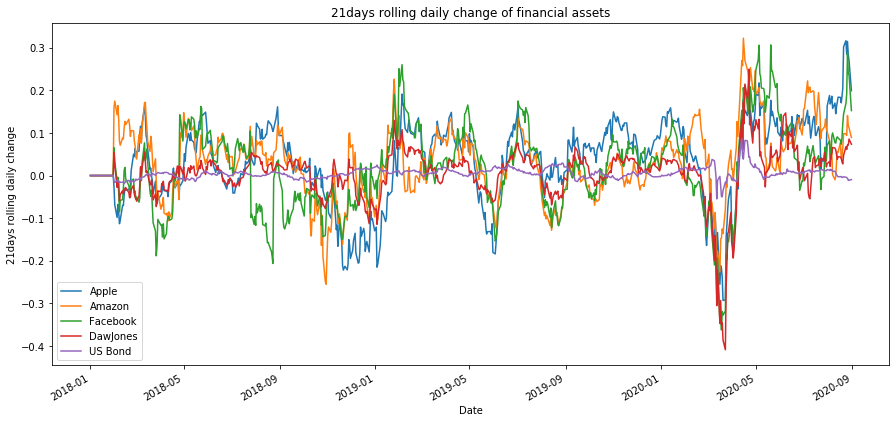

In [8]:
%matplotlib inline
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
rolling_pct_change.plot(ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('21days rolling daily change')
ax1.set_title('21days rolling daily change of financial assets')
plt.show()

In [9]:
# calculate daily percent change and 21 days rolling standard deviation
rolling_std = df.pct_change().rolling(21).std().fillna(0)
rolling_std.tail()

,Apple,Amazon,Facebook,DawJones,US Bond
Date,,,,,
2020-08-25,0.028586,0.017551,0.025808,0.006842,0.001794
2020-08-26,0.027750,0.017507,0.029716,0.006393,0.001788
2020-08-27,0.028341,0.017946,0.031574,0.006385,0.001874
2020-08-28,0.028532,0.017979,0.031621,0.005783,0.001882
2020-08-31,0.020066,0.016619,0.027256,0.006337,0.001991


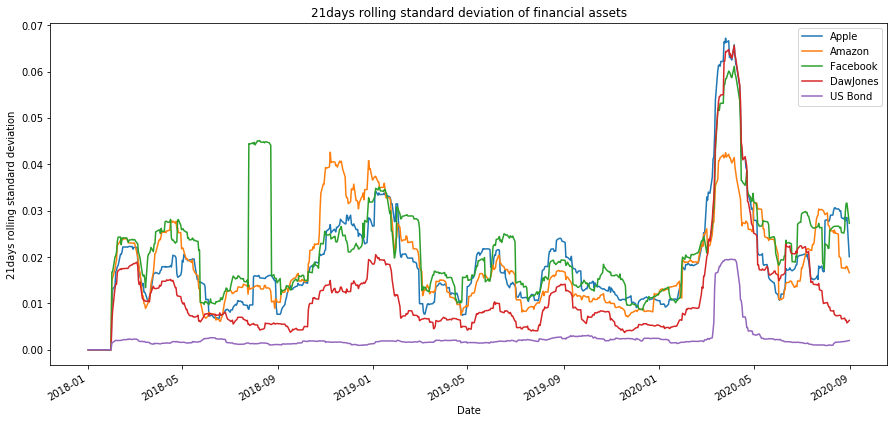

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(1, 1, 1)
rolling_std.plot(ax=ax2)
ax2.set_xlabel('Date')
ax2.set_ylabel('21days rolling standard deviation')
ax2.set_title('21days rolling standard deviation of financial assets')
plt.show()

In [11]:
# calculate daily percent change and 21 days correlations with DawJones
df_ = df.pct_change().rolling(21)
correlation_change = rolling_pct_change.copy()
correlation_change['Apple'] = df_['DawJones'].corr(df['Apple'].pct_change().fillna(0))
correlation_change['Amazon'] = df_['DawJones'].corr(df['Amazon'].pct_change().fillna(0))
correlation_change['Facebook'] = df_['DawJones'].corr(df['Facebook'].pct_change().fillna(0))
correlation_change['US Bond'] = df_['DawJones'].corr(df['US Bond'].pct_change().fillna(0))
correlation_change.drop('DawJones', axis=1, inplace=True) # DawJones was the key
correlation_change.tail()

,Apple,Amazon,Facebook,US Bond
Date,,,,
2020-08-25,0.366087,0.209265,0.100976,0.024024
2020-08-26,0.309307,0.107569,0.015485,0.060173
2020-08-27,0.283379,0.081436,-0.012776,0.005337
2020-08-28,0.298125,0.088603,-0.039814,0.079111
2020-08-31,0.262249,0.025655,-0.017713,-0.093799


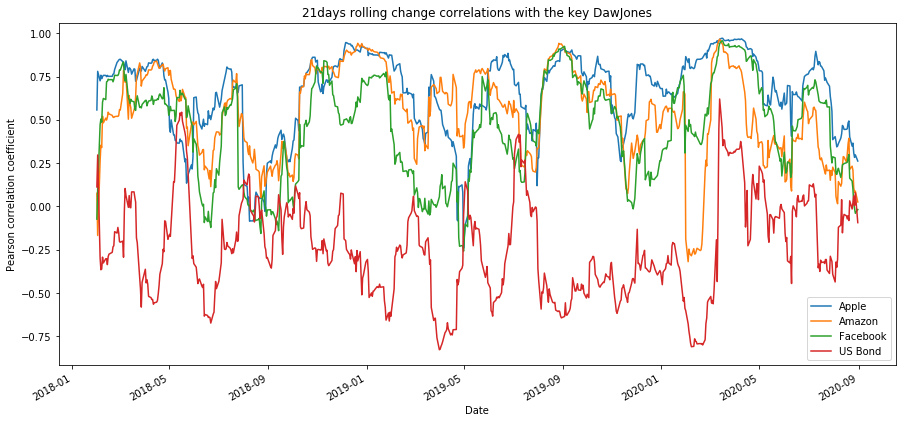

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(15, 7))
ax3 = fig.add_subplot(1, 1, 1)
correlation_change.plot(ax=ax3)
ax3.set_xlabel('Date')
ax3.set_ylabel('Pearson correlation coefficient')
ax3.set_title('21days rolling change correlations with the key DawJones')
plt.show()